# Performance evaluation on the accelerator

## Experiments on the accelerator

The following script was used to test the capabilities of the agents to correct perturbations. For brevity, the live-plot of the episode was removed. Every 7th step a random action was selected, simulating perturbations.

On the accelerator, an old version of the environment was used that was mainly designed for numerical optimizers. Thereby, it was ensured that the performance of the present solution, BOBYQA, was not deteriorated by any changes in the environment. The agents could interact with this environment via two wrapper-functions, which are part of the script below. In the future, it is planned to update the environment such that numerical optimizers and the RL-agents proposed in this thesis can interact with it directly.

In [ ]:
# Test capability of RL agents to recover settings after perturbations

import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import datetime
from pyjapc import PyJapc
from stable_baselines3 import PPO
from sb3_contrib import RecurrentPPO
from mkpdelays_env import MKPOptEnv

# ------------- INITIALIZE JAPC ----------------------
japc = PyJapc(selector="SPS.USER.LHCMD3", incaAcceleratorName="SPS", noSet=False)
# ----------------------------------------------------

# ------------- Global Parameters --------------------
acqStamp = 3415  # for LHCINDIV, 4615 for LHC10.0
bunch_index_width = 1  # default value 1, if no bunch train
saveplot = True  # choose to save plots or not
recurrent = True

ts = 5040
dtc = 200  # batch spacing

TIMESTAMP = str(datetime.datetime.now()).replace(" ", "_").replace(":", "-")

# folder for saving data and plots
save_string = 'plots_and_data_RL_agents/RPPO_15ns_{}_dtc_{}_beam_ts_{}'.format(dtc, ts, TIMESTAMP)

if not os.path.exists(save_string):
    os.makedirs(save_string)

# agent for evaluation
if recurrent:
    model = RecurrentPPO.load('agents/experiment_154/model_1000000_steps_200_ns_dtc_RecurrentPPO_run_154.zip')
else:
    model = PPO.load('agents/experiment_151/model_1000000_steps_200_ns_dtc_PPO_run_151.zip', 
                     custom_objects={"clip_range": 0.2, "lr_schedule": "Linear"})

max_steps = 1000
# ----------------------------------------------------
# initialize env
mkp_env = MKPOptEnv(japc, bunch_index_width=bunch_index_width, acqStamp=acqStamp)

mkp_env.reset()

def _step(delta_action, off_set, action_scaling):
    """
    Wraps around the step() function of the environment.
    Converts delta action and current off_set into absolute action.
    Then feeds it into the environment.

    :param delta_action: action selected by agent.
    :param off_set: sum of delta actions taken so far.
    :param action_scaling: scaling factor the agent has been trained with.
    :return: reward and absolute action.
    """
    delta_action = np.append(delta_action, 0)  # general delay remains constant

    action = off_set + delta_action * action_scaling * 1000  # conversion to real action
    norm_action = mkp_env.norm_data(action)  # normalization for env

    state, reward, is_finalized, _ = mkp_env.step(norm_action)

    return reward, action


def get_state(ts, dtc, corr=None):
    """
    Exracts state information from the environment.
    Allows to shift the waveforms to correct for the ToF.

    :param ts: timestamp of the injected beam.
    :param dtc: batch spacing.
    :param corr: 8-dim array containing the shifts for the waveforms.
    :return: observation of the environment.
    """
    raw_state = []

    t = ts - dtc / 2.0  # center between inj and circ beam
    kick_data = mkp_env.kick_data

    for i in range(8):
        if corr is not None:
            t_ind = t - corr[i]
        else:
            t_ind = t

        t_ind = int((t_ind - (t_ind % 2)) / 2)   # kick data is even, with a spacing of 2ns

        min_index = t_ind - 64
        max_index = t_ind + 65

        # get maximum amplitude for normalization
        max_amplitude = np.max(kick_data[i * 2])

        kick = kick_data[(i * 2)][min_index:max_index:4].flatten()  # only append every second waveform (one per switch)
        kick = np.maximum(kick, np.zeros(len(kick)))  # ensure that waveforms are non-negative
        kick = 2 * kick / max_amplitude - 1  # normalize kick
        raw_state.append(np.array(kick))

    # horizontal deviations from BPM-data
    beampos = mkp_env.beampos
    x1bar = (abs(np.max(beampos[0]) - np.min(beampos[0]))) / 2  # circulating
    x2bar = (abs(np.max(beampos[1]) - np.min(beampos[1]))) / 2  # injected

    raw_state.append((2 * np.array([x2bar, x1bar]) / 15 - 1))  # normalized deviations
    raw_state = np.array(raw_state, dtype=object).flatten()
    state = np.concatenate(raw_state, axis=0)  # concatenate into 1D array

    return state


#--------------correction for the time of flight------
# shift length such that the starting point of the first tank is exactly at 0
shift = 64.01925 - 3.423 / 2

magnet_01 = 3.423 * (1 / 10)
magnet_02 = 3.423 * (3 / 10)
magnet_03 = 3.423 * (5 / 10)
magnet_04 = 3.423 * (7 / 10)
magnet_05 = 3.423 * (9 / 10)

magnet_06 = 67.64125 - 3.432 / 2 - shift + 3.423 * (1 / 10)
magnet_07 = 67.64125 - 3.432 / 2 - shift + 3.423 * (3 / 10)
magnet_08 = 67.64125 - 3.432 / 2 - shift + 3.423 * (5 / 10)
magnet_09 = 67.64125 - 3.432 / 2 - shift + 3.423 * (7 / 10)
magnet_10 = 67.64125 - 3.432 / 2 - shift + 3.423 * (9 / 10)

magnet_11 = 70.44175 - 1.78 / 2 - shift + 1.78 * (1 / 4)
magnet_12 = 70.44175 - 1.78 / 2 - shift + 1.78 * (3 / 4)

magnet_13 = 73.24225 - 3.423 / 2 - shift + 3.423 * (1 / 8)
magnet_14 = 73.24225 - 3.423 / 2 - shift + 3.423 * (3 / 8)
magnet_15 = 73.24225 - 3.423 / 2 - shift + 3.423 * (5 / 8)
magnet_16 = 73.24225 - 3.423 / 2 - shift + 3.423 * (7 / 8)

# speed of light in m / ns
c = 299792458 / 1e9

# shift, such that the center of the first magnet is 0
general_shift = 3.423 * (1 / 10) / c

correction = -1 / c * np.array([magnet_01,
                                magnet_03,
                                magnet_05,
                                magnet_07,
                                magnet_09,
                                magnet_11,
                                magnet_13,
                                magnet_15])
correction += general_shift
# ----------------------------------------------------

# get initial settings
off_set = np.array(mkp_env.x0_action)
t = ts - dtc / 2.0  # center between inj and circ beam

# for recurrent policies
episode_starts = np.ones(1, dtype=bool)
lstm_states = None

# take actions
for i in np.arange(0, max_steps):
    # retrieve observation
    obs = get_state(ts=ts, dtc=dtc, corr=correction)
    
    if (i % 7) == 4: # every 7th action is randomly selected, simulates perturbations
        delta_action = np.zeros(8)
        index = np.random.randint(0, 8, 1)[0]
        delta_action[index] = np.random.choice(np.array([-1, 1])) * np.random.uniform(low=(1.0 / 3.0), high=(2.0 / 3.0))
    
    else:  # agent selects action
        if recurrent:
            delta_action, lstm_states = model.predict(obs, state=lstm_states, episode_start=episode_starts, deterministic=True)
        else:
            delta_action, _ = model.predict(obs, deterministic=True)

    # for recurrent policies
    episode_starts = np.zeros(1, dtype=bool)

    # take action
    reward, off_set = _step(delta_action=delta_action, off_set=off_set, action_scaling=0.015)

# for logging purposes, after the final action
obs = get_state(ts=ts, dtc=dtc, corr=correction)  


## Results of the first episode

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

# update some global settings for plots
plt.rcParams.update({
    'font.family': 'sans-serif',  
    'font.size': 11, 
    'font.weight': 'heavy',
    'axes.labelweight': 'heavy',
    'axes.titleweight': 'heavy',
})

In [4]:
# load logs from the accelerator
with open('data/actors_mkp_delays_log_data_rec_True_2024-03-15_17-11-57.354733_beamts_5040_perturbations.pickle', 'rb') as f:
    real_machine_data = pickle.load(f)

# initial normalized action is missing, insert manually
real_machine_data["actions"].insert(0, np.zeros(9))

# calculate reward from BPM-data
reward= []

for ele in real_machine_data["bpm_pos"]:
    x1bar = np.abs(np.max(ele[1]) - np.min(ele[1])) / 2 / 1000
    x2bar = np.abs(np.max(ele[0]) - np.min(ele[0])) / 2 / 1000
    
    rew = -1 * (x1bar ** 2 + x2bar ** 2 + (x1bar - x2bar) ** 2)
    
    reward.append(2 * (rew - (-1e-3)) / (-1e-4 - (-1e-3)) - 1)

reward = np.array(reward)

actions_all= []
for ele in real_machine_data["actions"]:
    actions_all.append(ele[0:8])

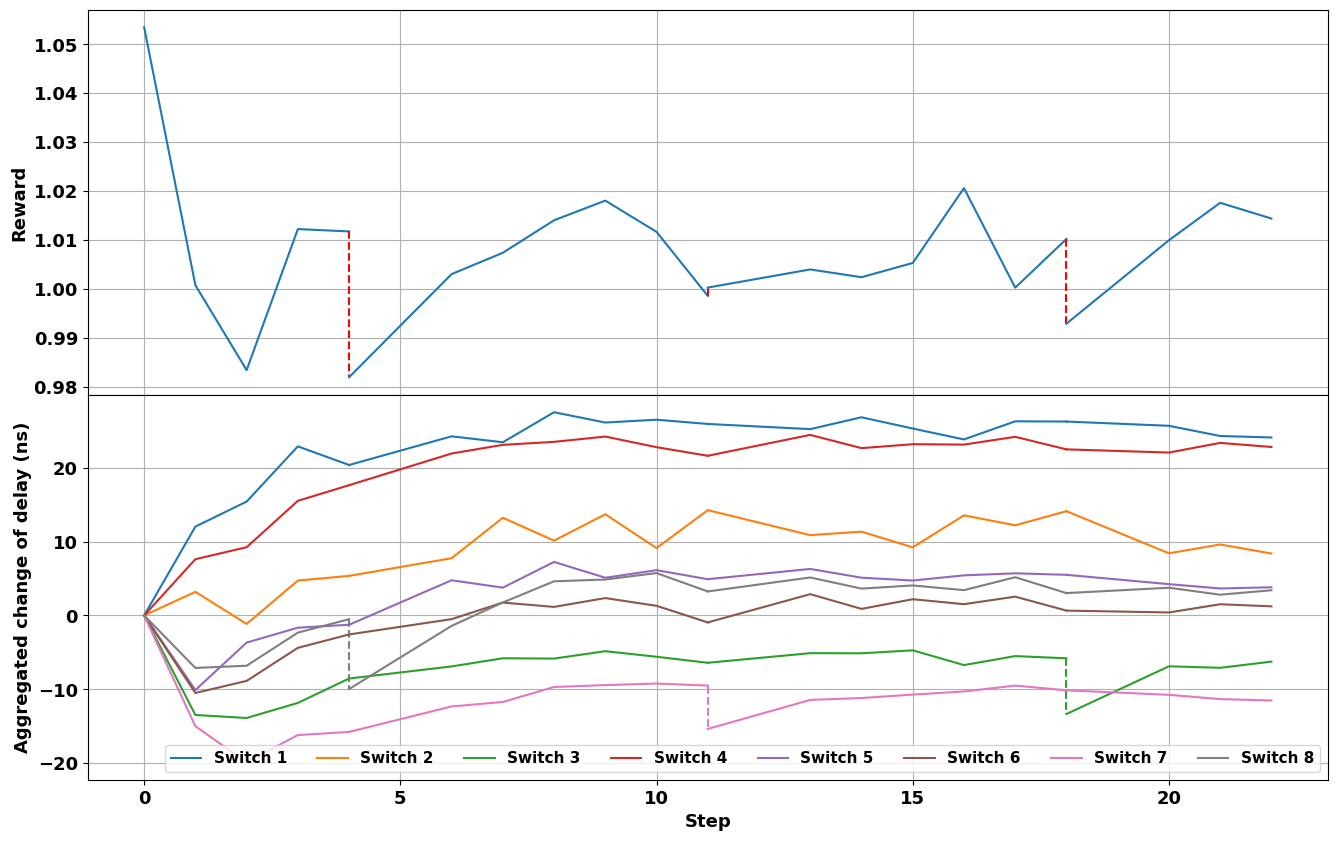

In [5]:
# plot results
fig, axis = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(16, 10))
axis[0].plot([], [])
axis[1].plot([], [])
axis[0].yaxis.label.set_size(16)
axis[0].tick_params(axis="y", labelsize=13)
axis[1].yaxis.label.set_size(16)
axis[1].xaxis.label.set_size(16)
axis[1].tick_params(axis="x", labelsize=13)
axis[1].tick_params(axis="y", labelsize=13)
legend_names = [
    "Switch 1",
    "Switch 2",
    "Switch 3",
    "Switch 4",
    "Switch 5",
    "Switch 6",
    "Switch 7",
    "Switch 8",
]

# simulated perturbations are not considered as step of the env
steps = np.zeros(len(reward))
for i in np.arange(0, len(reward)):
    if (i % 7) == 5:
        steps[i] = i - 1
    else:
        steps[i] = i

# indices of the perturbations
forced_actions = np.array([7 * x + 5 for x in np.arange(0, 3)])

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# plot reward and actions up to the first forced action
for ax in axis:
    ax.cla()
axis[0].plot(steps[0:forced_actions[0]], 
             reward[0:forced_actions[0]], 
             color='#1f77b4')

for j in np.arange(0, len(actions_all[0])):
    axis[1].plot(steps[0:forced_actions[0]], 
                 [arr[j] * 100 for arr in actions_all[0:forced_actions[0]]],
                 color = colors[j],
                 label = 'Switch {}'.format(j+1))


# plot remaining rewards and actions
for i in np.arange(0, len(forced_actions)):
    # reward change due to perturbation
    axis[0].plot(steps[forced_actions[i] - 1: forced_actions[i] + 1], 
                 reward[forced_actions[i] - 1: forced_actions[i] + 1], 
                 linestyle='--',
                 color='red')
    
    # forced action (simulates perturbation)
    for j in np.arange(0, len(actions_all[0])):
        axis[1].plot(steps[forced_actions[i] - 1: forced_actions[i] + 1], 
                     [arr[j] * 100 for arr in actions_all[forced_actions[i] - 1: forced_actions[i] + 1]],
                     linestyle='--',
                     color = colors[j])
        
    # actions from the agent and resulting rewards
    if i < len(forced_actions) - 1:
        # rewards
        axis[0].plot(steps[forced_actions[i]:forced_actions[i + 1]], 
                     reward[forced_actions[i]:forced_actions[i + 1]],
                     color='#1f77b4')
        
        # actions
        for j in np.arange(0, len(actions_all[0])):
            axis[1].plot(steps[forced_actions[i]:forced_actions[i + 1]], 
                         [arr[j] * 100 for arr in actions_all[forced_actions[i]:forced_actions[i + 1]]],
                         color = colors[j])
        
    else:
        # rewards
        axis[0].plot(steps[forced_actions[i]:len(steps)], 
                     reward[forced_actions[i]:len(reward)],
                     color='#1f77b4')
        
        # actions
        for j in np.arange(0, len(actions_all[0])):
            axis[1].plot(steps[forced_actions[i]:len(steps)], 
                         [arr[j] * 100 for arr in actions_all[forced_actions[i]:len(reward)]],
                         color = colors[j])

axis[0].set_ylabel("Reward", fontsize=13)
axis[0].grid()
axis[1].set_xlabel("Step", fontsize=13)
axis[1].set_ylabel("Aggregated change of delay (ns)", fontsize=13)
axis[1].legend(loc="lower right", fancybox=True, ncol=8)
axis[1].grid()
plt.subplots_adjust(wspace=0, hspace=0)
fig.canvas.draw()
axis[0].sharex(axis[1])  # make the subplots share the x-axis of iterations

fig.savefig('plots/real_machine_rec_ppo_general_shift_1.pdf', dpi=250)

## Results of the second episode

In [7]:
# load logs from the accelerator
with open('data/actors_mkp_delays_log_data_rec_True_2024-03-15_17-39-27.504243_beamts_5040_perturbations.pickle', 'rb') as f:
    real_machine_data = pickle.load(f)

# initial normalized action is missing, insert manually
real_machine_data["actions"].insert(0, np.zeros(9))

# calculate reward from BPM-data
reward= []

for ele in real_machine_data["bpm_pos"]:
    x1bar = np.abs(np.max(ele[1]) - np.min(ele[1])) / 2 / 1000
    x2bar = np.abs(np.max(ele[0]) - np.min(ele[0])) / 2 / 1000
    
    rew = -1 * (x1bar ** 2 + x2bar ** 2 + (x1bar - x2bar) ** 2)
    
    reward.append(2 * (rew - (-1e-3)) / (-1e-4 - (-1e-3)) - 1)

reward = np.array(reward)

actions_all= []
for ele in real_machine_data["actions"]:
    actions_all.append(ele[0:8])

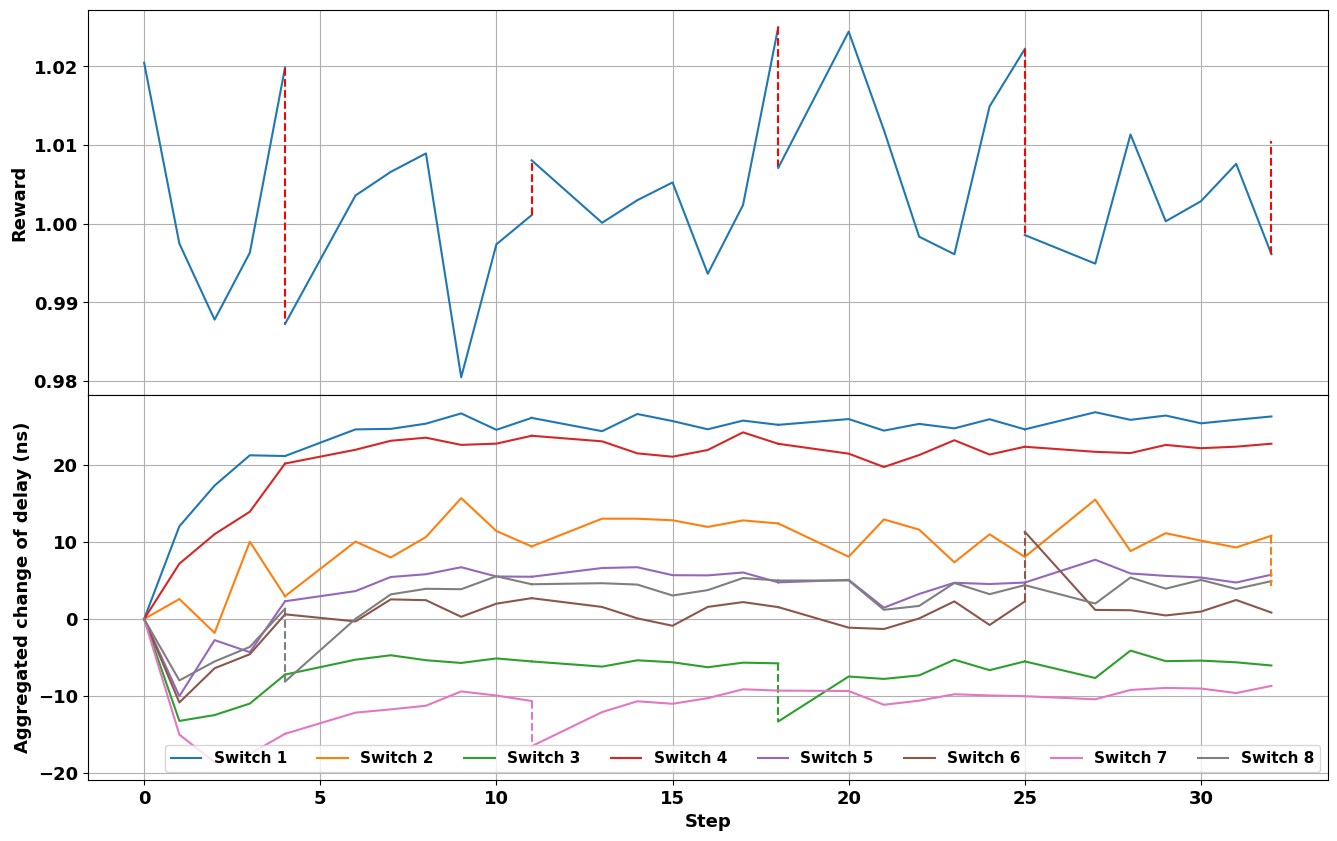

In [8]:
# plot results
fig, axis = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(16, 10))
axis[0].plot([], [])
axis[1].plot([], [])
axis[0].yaxis.label.set_size(16)
axis[0].tick_params(axis="y", labelsize=13)
axis[1].yaxis.label.set_size(16)
axis[1].xaxis.label.set_size(16)
axis[1].tick_params(axis="x", labelsize=13)
axis[1].tick_params(axis="y", labelsize=13)
legend_names = [
    "Switch 1",
    "Switch 2",
    "Switch 3",
    "Switch 4",
    "Switch 5",
    "Switch 6",
    "Switch 7",
    "Switch 8",
]

# simulated perturbations are not considered as step of the env
steps = np.zeros(len(reward))
for i in np.arange(0, len(reward)):
    if (i % 7) == 5:
        steps[i] = i - 1
    else:
        steps[i] = i

# indices of the perturbations
forced_actions = np.array([7 * x + 5 for x in np.arange(0, 5)])

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# plot reward and actions up to the first forced action
for ax in axis:
    ax.cla()
axis[0].plot(steps[0:forced_actions[0]], 
             reward[0:forced_actions[0]], 
             color='#1f77b4')

for j in np.arange(0, len(actions_all[0])):
    axis[1].plot(steps[0:forced_actions[0]], 
                 [arr[j] * 100 for arr in actions_all[0:forced_actions[0]]],
                 color = colors[j],
                 label = 'Switch {}'.format(j+1))


# plot remaining rewards and actions
for i in np.arange(0, len(forced_actions)):
    # reward change due to perturbation
    axis[0].plot(steps[forced_actions[i] - 1: forced_actions[i] + 1], 
                 reward[forced_actions[i] - 1: forced_actions[i] + 1], 
                 linestyle='--',
                 color='red')
    
    # forced action (simulates perturbation)
    for j in np.arange(0, len(actions_all[0])):
        axis[1].plot(steps[forced_actions[i] - 1: forced_actions[i] + 1], 
                     [arr[j] * 100 for arr in actions_all[forced_actions[i] - 1: forced_actions[i] + 1]],
                     linestyle='--',
                     color = colors[j])
        
    # actions from the agent and resulting rewards
    if i < len(forced_actions) - 1:
        # rewards
        axis[0].plot(steps[forced_actions[i]:forced_actions[i + 1]], 
                     reward[forced_actions[i]:forced_actions[i + 1]],
                     color='#1f77b4')
        
        # actions
        for j in np.arange(0, len(actions_all[0])):
            axis[1].plot(steps[forced_actions[i]:forced_actions[i + 1]], 
                         [arr[j] * 100 for arr in actions_all[forced_actions[i]:forced_actions[i + 1]]],
                         color = colors[j])
        
    else:
        # rewards
        axis[0].plot(steps[forced_actions[i]:len(steps)], 
                     reward[forced_actions[i]:len(reward)],
                     color='#1f77b4')
        
        # actions
        for j in np.arange(0, len(actions_all[0])):
            axis[1].plot(steps[forced_actions[i]:len(steps)], 
                         [arr[j] * 100 for arr in actions_all[forced_actions[i]:len(reward)]],
                         color = colors[j])

axis[0].set_ylabel("Reward", fontsize=13)
axis[0].grid()
axis[1].set_xlabel("Step", fontsize=13)
axis[1].set_ylabel("Aggregated change of delay (ns)", fontsize=13)
axis[1].legend(loc="lower right", fancybox=True, ncol=8)
axis[1].grid()
plt.subplots_adjust(wspace=0, hspace=0)
fig.canvas.draw()
axis[0].sharex(axis[1])  # make the subplots share the x-axis of iterations

fig.savefig('plots/real_machine_rec_ppo_general_shift_1.pdf', dpi=250)